In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
path = '/content/gdrive/MyDrive/PR-lfw/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


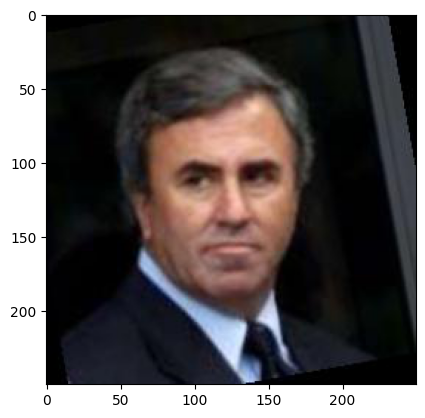

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

In [ ]:
# In terms of Applications, the difference between autoencoders and VAEs are: 
# Autoencoders are used for data compression and feature learning. Whilest VAE are used for generating new data points.
# Architecture wise, Both of them have encoders and decoders but VAE has probabilistic layer and autoencoder's decoder restructures the input from latent representation.
# Autoencoder uses MSE to determine difference between input and reconstructed output. VAE uses combination of reconstruction loss.
# In short, autoencoders learn a deterministic representation whereas VAE learn the parameters of a probability distribution to represent the data.
# VAE can generate new samples by sampling the learned latent distribution

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()

        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * 63 * 63, latent_size)  
        self.fc_logvar = nn.Linear(64 * 63 * 63, latent_size)

        self.fc_decoder = nn.Linear(latent_size, 64 * 63 * 63)  
        self.decoder_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = x.view(x.size(0), -1)  
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decoder(self, x):
        x = F.relu(self.fc_decoder(x))
        x = x.view(x.size(0), 64, 63, 63)  
        x = F.relu(self.decoder_conv1(x))
        x = torch.sigmoid(self.decoder_conv2(x))
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [9]:

latent_size = 64 
vae_model = VAE(latent_size)

for x, y in dataloader:
    input_image = x[0].unsqueeze(0)
    break

recon_image, mu, logvar = vae_model(input_image)

print("Shape of Mean (mu):", mu.shape)
print("Shape of Log Variance (logvar):", logvar.shape)

with torch.no_grad():
    latent_sample = vae_model.reparameterize(mu, logvar)

print("Shape of generated Latent Sample:", latent_sample.shape)

generated_image = vae_model.decoder(latent_sample)

print("Shape of generated Image:", generated_image.shape)

# Generating new samples in the latent space of a Variational Autoencoder (VAE) involves using reparameterization trick. 
# It is a technique that allows the model to generate new samples in a differentiable manner, making it possible to train the VAE using gradient-based optimization. 

# Gradients are usually not established for random sampling procedures in normal backpropagation. 
# Gradients can be computed through the sampling process thanks to the reparameterization approach, 
# which introduces a deterministic transformation that separates the sampling operation from the distribution's parameters. 
# This is essential for applying gradient-based optimization techniques to train the VAE.

# Interpretation: A point in the latent space where each dimension relates to a feature or attribute is represented by the latent variable z.
# We can create a variety of samples in the latent space by sampling fresh values for z.
# These latent samples are transformed back into the data space by the decoder, producing new pictures.
# Through this approach, the VAE is able to generate new and realistic samples in the data space by learning a meaningful and continuous latent representation. 
# By maintaining the training process's differentiability, the reparameterization approach makes it easier to optimize the model's parameters.

Shape of Mean (mu): torch.Size([1, 64])
Shape of Log Variance (logvar): torch.Size([1, 64])
Shape of generated Latent Sample: torch.Size([1, 64])
Shape of generated Image: torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [11]:

import torch.optim as optim

latent_size = 64  
vae_model = VAE(latent_size)

total_params = sum(p.numel() for p in vae_model.parameters())
print("Total Number of Parameters in the VAE Model:", total_params)

class VAE_Loss(nn.Module):
    def __init__(self):
        super(VAE_Loss, self).__init__()

    def forward(self, recon_x, x, mu, logvar):
        reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')

        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        total_loss = reconstruction_loss + kl_divergence_loss

        return total_loss

loss_function = VAE_Loss()
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)

# The VAE's ability to reconstruct the input data from its latent representation is gauged by the reconstruction loss and this is our goal.
#  This is usually the Mean Squared Error (MSE) of the data reconstruction over the input data. Reduce as much as possible the discrepancy between the original input and the output that was rebuilt.

# The KL divergence loss penalizes departures from a conventional normal distribution, therefore regularizing the latent space.
# It is the KL divergence between the conventional normal distribution and the learnt distribution in the latent space.
# Promote a basic distribution and organization in the latent space.

# Justification
# This parameter guarantees accurate reconstruction of the input data by the VAE. The model is encouraged to learn meaningful 
# representations in the latent space that can precisely recreate the original input by minimizing this loss.

# The latent space is regularized by this term. The distribution of latent vectors is encouraged to resemble 
# a conventional normal distribution by minimizing this loss. It guarantees a smooth and well-organized latent space and aids in the prevention of overfitting.

# overall Loss: The reconstruction loss plus the KL divergence loss add up to the overall loss. During training, the model seeks to reduce this total loss.

# Optimizer: Adam is the optimizer in this instance. The well-liked optimization algorithm Adam modifies the learning rate for every parameter separately. 
# It works well for neural network training and blends concepts from momentum and RMSprop.

# Learning Rate: During optimization, the number of steps done is determined by the learning rate. 
# It is a hyperparameter that must be adjusted in accordance with the particular issue. Although it could cause delayed convergence, 
# a lower learning rate can help avoid going over the ideal solution.

Total Number of Parameters in the VAE Model: 49063939


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [12]:

num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0

    for data in dataloader:
        inputs, _ = data

        optimizer.zero_grad()

        recon_x, mu, logvar = vae_model(inputs)

        loss = loss_function(recon_x, inputs, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
# initially, I noticed that the loss was not decreasing and it was variably changing. So, I tried adjusting the learning rate.
    # I also added more layers to increase the capacity and complexity. I tried playing around with model's architecture and made it suitable for the dataset.
    #  Also tried training it on high number of epochs and also changed the batch size

Epoch [1/10], Loss: 242542.0558
Epoch [2/10], Loss: 130397.4277
Epoch [3/10], Loss: 109477.7864
Epoch [4/10], Loss: 98486.0142
Epoch [5/10], Loss: 93171.0944
Epoch [6/10], Loss: 89502.2458
Epoch [7/10], Loss: 86511.8594
Epoch [8/10], Loss: 84089.2900
Epoch [9/10], Loss: 81610.5106
Epoch [10/10], Loss: 79508.7204


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

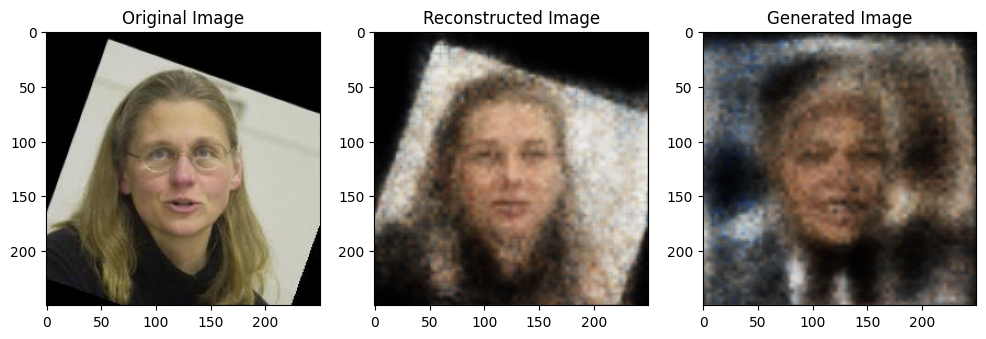

In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np


for x, y in dataloader:
    original_image = x[0].unsqueeze(0)
    break

with torch.no_grad():
    reconstructed_image, _, _ = vae_model(original_image)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_image[0].permute(1, 2, 0).numpy())
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image[0].detach().permute(1, 2, 0).numpy())
plt.title("Reconstructed Image")

latent_sample = torch.randn(1, latent_size)  
generated_image = vae_model.decoder(latent_sample)

plt.subplot(1, 3, 3)
plt.imshow(generated_image[0].detach().permute(1, 2, 0).numpy())
plt.title("Generated Image")

plt.show()
